In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [3]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

IMG_HEIGHT = 412
IMG_WIDTH = 424
NUM_CHANNELS = 1
TRAIN_SIZE = 1626
VAL_SIZE = 200
TEST_SIZE = 1000

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    train_list = [
        ['half_res_train_pr_19510101-19551231.pkl', 'pr_19510101-19551231.pickle'],
    ]

    test_list = [
        ['lr_data_train.pkl', 'hr_data_train.pkl'],
    ]

    def __init__(self, root, train=True, transform=None, target_transform=None):
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        # now load the pickled numpy arrays
        if self.train:
            self.train_in = []
            self.train_out = []
            for fentry in self.train_list:
                fin = fentry[0]
                file_in = os.path.join(self.root, self.base_folder, fin)
                fo_in = open(file_in, 'rb')
                entry_in = pickle.load(fo_in)
                self.train_in.append(entry_in)
                fo_in.close()
                
                fout = fentry[1]
                file_out = os.path.join(self.root, self.base_folder, fout)
                fo_out = open(file_out, 'rb')
                entry_out = pickle.load(fo_out)
                self.train_out.append(entry_out)
                fo_out.close()

            self.train_in = np.concatenate(self.train_in)
            self.train_in = self.train_in.reshape((TRAIN_SIZE+VAL_SIZE, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
            #self.train_in = self.train_in.transpose((0, 2, 3, 1))  # convert to HWC
            
            self.train_out = np.concatenate(self.train_out)
            self.train_out = self.train_out.reshape((TRAIN_SIZE+VAL_SIZE, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
            #self.train_out = self.train_out.transpose((0, 2, 3, 1))  # convert to HWC
            
            print("input size (bytes): ", self.train_in.nbytes)
            print("output size (bytes): ", self.train_out.nbytes)
            
        else:
            fentry = self.test_list[0]
            
            fin = fentry[0]
            file_in = os.path.join(self.root, self.base_folder, fin)
            fo_in = open(file_in, 'rb')
            entry_in = pickle.load(fo_in)
            self.train_in.append(entry_in)
            fo_in.close()
                
            fout = fentry[1]
            file_out = os.path.join(self.root, self.base_folder, fout)
            fo_out = open(file_out, 'rb')
            entry_out = pickle.load(fo_out)
            self.train_out.append(entry_out)
            fo_out.close()
            
            self.test_in = np.concatenate(self.test_in)
            self.test_in = self.test_in.reshape((TEST_SIZE, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
            #self.test_in = self.test_in.transpose((0, 2, 3, 1))  # convert to HWC
            
            self.test_out = np.concatenate(self.test_out)
            self.test_out = self.test_out.reshape((TEST_SIZE, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
            #self.test_out = self.test_out.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_in[index], self.train_out[index]
        else:
            img, target = self.test_in[index], self.test_out[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        #img = Image.fromarray(img)
        #target = Image.fromarray(target)
        img = torch.from_numpy(img)
        target = torch.from_numpy(target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [4]:
transform = T.Compose([
                #T.ToTensor()#,
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

data_directory = '.'

batch_size = 100

sr_train = SR_Dataset(data_directory, train=True, transform=transform, target_transform=transform)
loader_train = DataLoader(sr_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_SIZE)))

#sr_val = SR_Dataset(data_directory, train=True, transform=transform, target_transform=transform)
#loader_val = DataLoader(sr_val, batch_size=batch_size, 
#                        sampler=sampler.SubsetRandomSampler(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE)))

#sr_test = SR_Dataset(data_directory, train=True, transform=transform)
#loader_test = DataLoader(sr_test, batch_size=batch_size)

input size (bytes):  1275921152
output size (bytes):  1275921152


In [5]:
# used https://github.com/togheppi/pytorch-super-resolution-model-collection/blob/master/srcnn.py to get basic idea
hidden_channels = 8

class SRCNN(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential( # this is the original SRCNN from Dong et al. 2015
            nn.Conv2d(num_channels, hidden_channels, 9, padding=4),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels//2, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_channels//2, num_channels, 5, padding=2)
        )
        
    def forward(self, x):
        return self.layers(x)

In [6]:
def test_SRCNN():
    x = torch.zeros((64, NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = SRCNN(NUM_CHANNELS)
    scores = model(x)
    print(scores.size())
test_SRCNN()

torch.Size([64, 1, 412, 424])


In [7]:
def train_it(optimizer, model, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][0].detach().numpy())
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][0].detach().numpy())
                plt.subplot(1,3,3)
                plt.imshow(y[0][0].detach().numpy())
                plt.show()
                
                #check_accuracy(loader_val, model)
                
            del x, y, loss

Iteration 0, loss = 0.0104


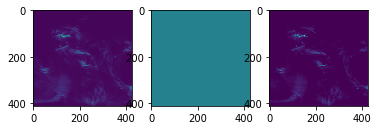

Iteration 1, loss = 0.0103


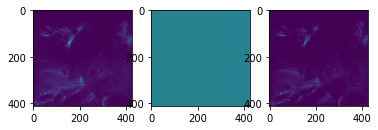

Iteration 2, loss = 0.0091


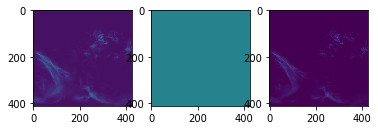

Iteration 3, loss = 0.0090


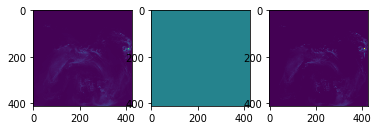

Iteration 4, loss = 0.0089


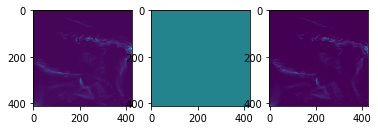

Iteration 5, loss = 0.0085


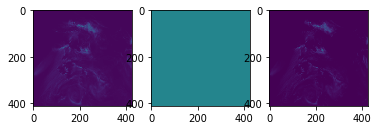

Iteration 6, loss = 0.0085


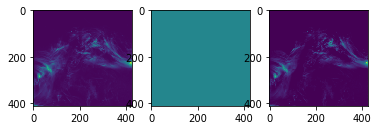

Iteration 7, loss = 0.0084


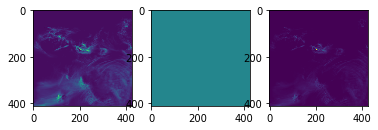

Iteration 8, loss = 0.0083


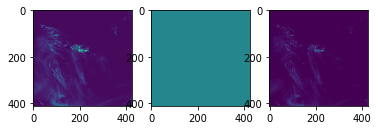

Iteration 9, loss = 0.0075


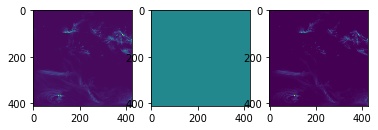

Iteration 10, loss = 0.0075


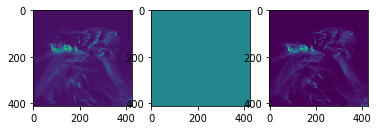

Iteration 11, loss = 0.0075


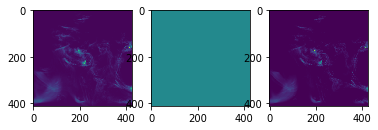

Iteration 12, loss = 0.0075


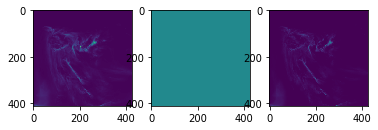

Iteration 13, loss = 0.0074


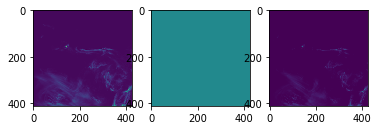

Iteration 14, loss = 0.0073


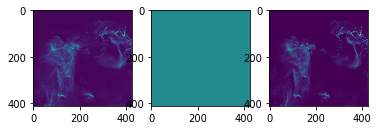

Iteration 15, loss = 0.0073


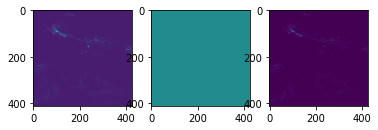

Iteration 16, loss = 0.0060


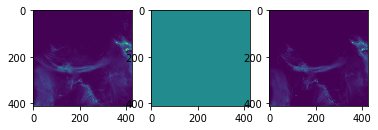

In [8]:
learning_rate = 1e-4

model = SRCNN(1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_it(optimizer, model)